<a href="https://colab.research.google.com/github/AbhishekMallaiah001/cs480student/blob/main/06/Copy_of_CS480_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

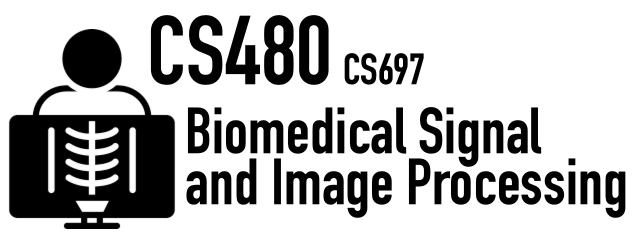
#Assignment 6

In [ ]:
# In this assignment, we will train a U-Net classifer to detect mitochondria
# in electron microscopy images!

In [ ]:
### IMPORTANT ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [1]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the unet tensorflow code
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-fuca_i6x
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-fuca_i6x
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25658 sha256=c3c1616f943f7bf0c30e7fb529e06dabff5177aff6bb76894baa080f750ef720
  Stored in directory: /tmp/pip-ephem-wheel-cache-ebfitb8c/wheels/f5/38/c8/8f0a157cfd7616cc1a24811a52b9a669c0ee8fccc9f99d3cbc
Successfully built unet


In [3]:
# .. and use it!
# Note: There are a ton of U-Net implementations but this one is easier to use!
import unet

**Task 1**: Study the unet circle example and learn about mitochondria! [15 Points]

In [ ]:
# The unet package allows to train a U-Net classifier with little code.
# As discussed in class, the U-Net can be used to label/segment/annotate images.

In [ ]:
# TODO: Please study the Circles example 
# https://github.com/jakeret/unet/blob/master/notebooks/circles.ipynb

In [ ]:
# TODO: ... and look how the (artificial) dataset is generated
# https://github.com/jakeret/unet/blob/master/src/unet/datasets/circles.py

In [ ]:
# 1) Question
# TODO: Please describe what the U-Net is trained to do.
#
# TODO: YOUR ANSWER

The U-net is convolutional network architecture for fast and precise segmentation of medical images. In the circles.py we are able to see the segmented image matches more than 90% to the original image (one of the best alogoritthm compare to prior ones). U-Net has encoder and decoder. The encoder is just a traditional stack of convolutional and max pooling layers. The decoder is used to enable precise localization using transposed convolutions. Thus it is an end-to-end fully convolutional network (FCN), i.e. it only contains Convolutional layers and does not contain any Dense layer because of which it can accept image of any size.

In [ ]:
# 2) Question
# TODO: In circles.py, what does the following mean:
#     channels = 1
#     classes = 2
#
# TODO: YOUR ANSWER

Channels:   Number of channels of the input tensors.

Classes :   2 classes represent the background and mitochondria.

In [ ]:
# 3) Question
# TODO: What are mitochondria and what is their appearance in
# electron microscopy data?
# Hint: You can validate your answer in Task 4!
#
# TODO: YOUR ANSWER

“powerhouses of the cell,” mitochondria produce the energy necessary for the cell's survival and functioning. Through a series of chemical reactions, mitochondria break down glucose into an energy molecule known as adenosine triphosphate (ATP), which is used to fuel various other cellular processes.

Mitochondria observed by electron microscopy in situ have a relatively large matrix volume that pushes part of the inner membrane up against the outer membrane with a small space between them; we call this the IBM.

**Task 2**: Setup a datagenerator for mitochondria images! [45 Points]

In [ ]:
# TODO: https://cs480.org/data/mito.npz
# Download  to your computer.
# Then, please upload mito.npz using the file panel on the left.

In [ ]:
# The code below is similar to the circles.py file from Task 1.
# We follow Tensorflow conventions to design a tf.data.Dataset for training
# the U-Net.
#
# TODO: Please add four different data augmentation methods in the code block
# below. (image normalization to 0..1, horizontal data flip, vertical data flip,
# rotation by 90 degrees)
#
# Hint: https://github.com/jakeret/unet/blob/master/src/unet/datasets/oxford_iiit_pet.py#L25

In [27]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List
import matplotlib.pyplot as plt


IMAGE_SIZE = (256, 256)
channels = 1
classes = 2

def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # here we load the mitochondria data
    loaded = np.load('mito.npz')
    loadedimages = loaded['arr_0'][0].copy()
    loadedmasks = loaded['arr_0'][1].copy()

    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))

    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
        
        #
        # TODO: Normalize the image to 0..1
        image = tf.image.per_image_standardization(image)
        # TODO: YOUR CODE


        #
        # TODO: Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:
          tf.image.random_flip_left_right(image, seed=None)
            #
            # TODO: YOUR CODE
            #

        #
        # TODO: Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:
          tf.image.random_flip_up_down(image, seed=None)
            #
            # TODO: YOUR CODE
            #

        #
        # TODO: Use Tensorflow to rotate the image 90 degrees
        rotation_degree = 90
        if tf.random.uniform(()) > 0.5:
          tf.image.rot90(image,k=1,name=None)
            #
            # TODO: YOUR CODE
            #



        # augmentation done, let's store the image
        images[i] = image

        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]
        count  = 0

    return images, labels

**Task 3**: Let's train the U-Net! [25 Points]

In [28]:
#
# We can now create our training, validation, and testing data by calling
# our methods from Task 2.
#
train, val, test = load_data( 660, splits=(0.7, 0.2, 0.1) )

In [ ]:
# 1) Question
# TODO: We have in total 660 images + 660 masks. Based on the code above,
# how many images are used for training alone?
#
# TODO: YOUR ANSWER

Traning data = (0.7) * 660 (70% of 660) = 462

In [29]:
#
# Let's setup the U-Net!
#
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [30]:
#
# And, let's setup the trainer...
#
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [31]:
#
# ...and train the U-Net for 50 epochs with a batch_size of 10!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use training and validation data.
# Hint 2: This will take roughly 30 minutes!
#
trainer.fit(unet_model,
            train,
            val,
            epochs=50,
            batch_size=10
            )

Epoch 1/50
47/47 [==============================] - 45s 913ms/step - loss: 0.6560 - categorical_crossentropy: 0.6560 - categorical_accuracy: 0.5935 - mean_iou: 0.2938 - dice_coefficient: 0.5369 - auc_5: 0.5969 - val_loss: 0.4247 - val_categorical_crossentropy: 0.4247 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3586 - val_dice_coefficient: 0.6610 - val_auc_5: 0.9817
Epoch 2/50
47/47 [==============================] - 41s 867ms/step - loss: 0.2316 - categorical_crossentropy: 0.2316 - categorical_accuracy: 0.9209 - mean_iou: 0.4833 - dice_coefficient: 0.8703 - auc_5: 0.9673 - val_loss: 0.2477 - val_categorical_crossentropy: 0.2477 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.4608 - val_dice_coefficient: 0.8060 - val_auc_5: 0.9905
Epoch 3/50
47/47 [==============================] - 41s 872ms/step - loss: 0.1838 - categorical_crossentropy: 0.1838 - categorical_accuracy: 0.9210 - mean_iou: 0.5318 - dice_coefficient: 0.8890 - auc_5: 0.9807 - val_loss: 0.2041 - val_categorical

**Task 4**: Let's predict mitochondria in the testing data! [15 Points]

In [ ]:
# 
# After training, let's try the U-Net on our testing data.
#
# The code below displays the first 10 input images, the original masks by experts, 
# and the predicted masks from the U-Net.

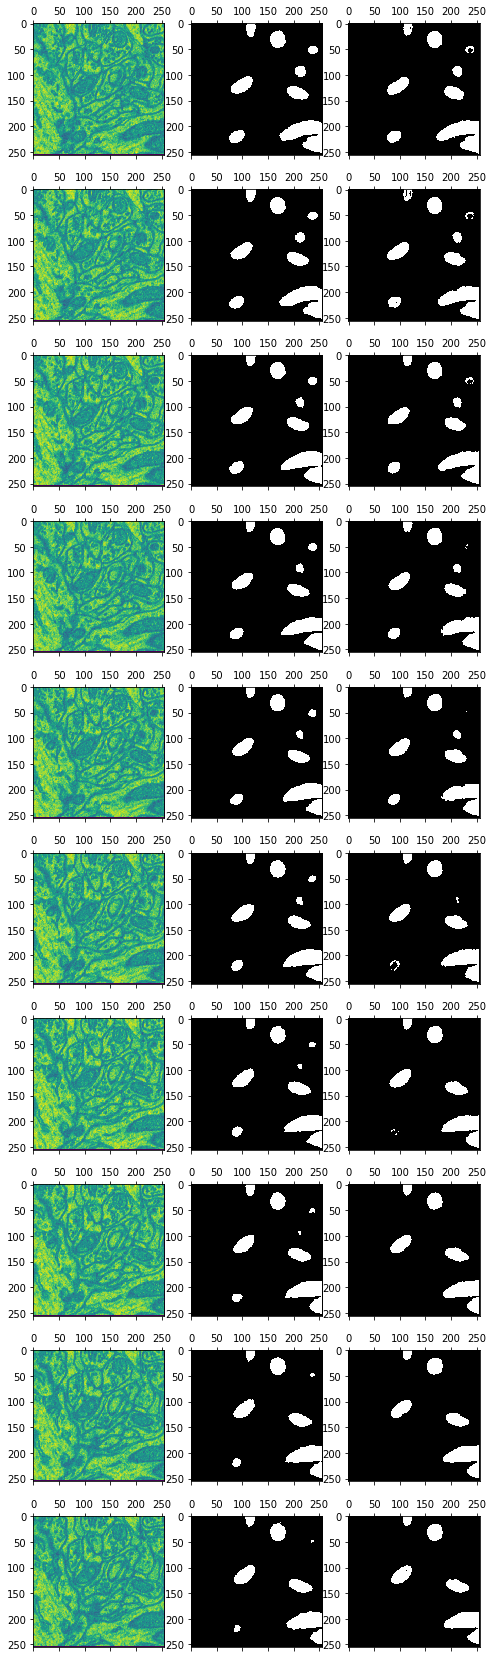

In [36]:
import matplotlib.pyplot as plt
from unet import utils

rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))

for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

In [ ]:
# 1) Question
# TODO: Why do we use the prediction[0].argmax(axis=-1) command
# to display the prediction?

# TODO: YOUR ANSWER

Argmax is used for finding the class with the largest predicted probability.
The axis value is -1 means it takes from the last index.

In [ ]:
# 2) Question
# TODO: Is the quality of the segmentation good and how could we improve it?
# Hint: Think along the lines of some traditional image processing rather than
# increasing the training data size.
#
# TODO: YOUR ANSWER

When i compared predicted result with the true label, which looks almost same in the visual comparision.                                             
We can improve symantic segmentation result by preprocessing the image like denoising.

**Bonus**: Compare against the state-of-the-art literature! [33 Points]

In [ ]:
#
# The following paper also uses a 2D U-Net to detect mitochondria:
# 
# https://danielhaehn.com/papers/?casser2020fast
#

In [ ]:
# 1) Question
#
# TODO: How many learnable parameters does your trained unet_model have?
# Hint: You can use TF's Model Summary function to answer this.
#

In [ ]:
# TODO: YOUR CODE

In [39]:
unet_model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_block_45 (ConvBlock)       (None, None, None, 6 37568       inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, None, None, 6 0           conv_block_45[0][0]              
__________________________________________________________________________________________________
conv_block_46 (ConvBlock)       (None, None, None, 1 221440      max_pooling2d_20[0][0]           
_______________________________________________________________________________________________

There are following paremeters.

Total params: 31,030,658                                                      
Trainable params: 31,030,658                                                  
Non-trainable params: 0
_________________________

In [ ]:
# 2) Question
#
# TODO: How many parameters do Casser et al. use?
#

Encoder uses 1,178,480 parameters.                             
Decoder uses 780,053 parameters.

In [ ]:
# 3) Question
#
# TODO: How did Casser et al. reduce the parameters?
#

By following steps                                                    
1.By reducing the number of convolutional filters throughout the network.       
2.By replacing transpose convolutions in the decoder with light-weight bilinear upsampling layers that require no parameters.

In [ ]:
# 4) Question
#
# TODO: Why did Casser et al. reduce the parameters?
#

In [ ]:
# TODO: YOUR ANSWER

To achieve high accuracy and fast processing times in the automated image segmentation.

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#